# Project 4: Train a Face Mask Detector using YOLO V3

## 1. Overview

In the last lesson, we have learned how to train a custom Object Detector using YOLO network for a single object. In this project, you will extend that learning by building a 2-Class Object Detector using Yolo v3 as well as the more recent Yolo v4. In the process, you will also learn how to browse other GitHub repositories and find out relevant information to complete your task.

Since Covid-19 has had such a huge impact on our lives, we will build a Mask and No-mask Detector. So, the classes are:

- Class 0 - Face with Mask
- Class 1 - Face without Mask

## Loading the libraries

In [1]:
import random
import os
import json
import shutil
import numpy as np
import cv2
import matplotlib
import IPython
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'
%matplotlib inline

## Cross-Platform Environment Configuration

In [2]:
RUNNING_IN_COLAB = 'google.colab' in str(get_ipython())
RUNNING_IN_LINUX = os.name in ('posix', 'Linux')
RUNNING_IN_WIN32 = os.name in ('win32', 'nt')

print('RUNNING_IN_COLAB', RUNNING_IN_COLAB)
print('RUNNING_IN_LINUX', RUNNING_IN_LINUX)
print('RUNNING_IN_WIN32', RUNNING_IN_WIN32)

RUNNING_IN_COLAB False
RUNNING_IN_LINUX False
RUNNING_IN_WIN32 True


In [10]:
FULL_PATH = IPython.extract_module_locals()[1]['_dh'][0]

if RUNNING_IN_LINUX:
    CONTENT_PATH = FULL_PATH
    DARKNET_PATH = f'{CONTENT_PATH}/third/darknet/darknet'
    !lsb_release -a
    pass
elif RUNNING_IN_WIN32:
    CONTENT_PATH = f'{FULL_PATH}\content'
    !mkdir -p {CONTENT_PATH}
    DARKNET_PATH = 'darknet'
    pass

!nvcc --version
print('FULL_PATH', FULL_PATH)
print('CONTENT_PATH', CONTENT_PATH)
print('DARKNET_PATH', DARKNET_PATH)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Fri_Dec_17_18:28:54_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.6, V11.6.55
Build cuda_11.6.r11.6/compiler.30794723_0
FULL_PATH c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector
CONTENT_PATH c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content
DARKNET_PATH darknet


## Checking nvidia instalation and cuda version

In [4]:
!nvidia-smi

Thu May  9 11:49:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.12                 Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8              12W / 140W |    114MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Building Darknet

We will first make some changes to the Makefile before we compile. Specifically, we will enable the following:
1. Build darknet with OpenCV
1. Build with CUDA enabled
1. Build with cuDNN enabled.

In [11]:
if RUNNING_IN_COLAB:
  if not os.path.exists(f'{CONTENT_PATH}/third/darknet/darknet'):
    !mkdir -p '/content/third'
    %cd /content/third
    !git clone https://github.com/AlexeyAB/darknet.git
    %cd darknet
    !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
    !sed -i 's/GPU=0/GPU=1/' Makefile
    !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
    !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

    print("Building. . . It might take 2-3 minutes")

    !make &> build_log.txt

  %cd {CONTENT_PATH}

  !{DARKNET_PATH} --version

## Set Here the YOLO Version

supported versions:
 - yolov3
 - yolov4

In [12]:
YOLO_VERSION = 'yolov3'
print('YOLO_VERSION', YOLO_VERSION)

YOLO_VERSION yolov3


## The Dataset

It contains images of people with mask and without mask and the annotations are given in the txt files. The Class 0 is for Face with Mask and Class 1 is for face without mask.

In [13]:
print(f'running in a {os.name} machine')
if RUNNING_IN_LINUX:
  if RUNNING_IN_COLAB:
    print('Running on CoLab')
    from google.colab import drive
    drive.mount(f'{CONTENT_PATH}/drive')
    PATH_TO_DATASET = f'{CONTENT_PATH}/drive/MyDrive/dataset/mask_no_mask_dataset'
    if not os.path.exists(f'{CONTENT_PATH}/drive/MyDrive/dataset') or not os.path.exists(f'{CONTENT_PATH}/drive/MyDrive/dataset/mask_no_mask_dataset'):
      print('Downloading the model and unzip it')
      !mkdir -p {PATH_TO_DATASET}
      !wget https://www.dropbox.com/s/uq0x32w70c390fb/mask_no-mask_dataset.zip?dl=1 -O mask_no-mask_dataset.zip
      !mv {CONTENT_PATH}/mask_no-mask_dataset.zip {PATH_TO_DATASET}/mask_no-mask_dataset.zip
      !unzip -d {PATH_TO_DATASET} {PATH_TO_DATASET}/mask_no-mask_dataset.zip
      !rm -rf {PATH_TO_DATASET}/mask_no-mask_dataset.zip
      pass
  else:
    PATH_TO_DATASET = f'{CONTENT_PATH}/dataset/mask_no_mask_dataset'
else:
  PATH_TO_DATASET = 'C:\\opencv.org\\DLAP\\datasets\\mask_no-mask_dataset'


DATASET_NAME = 'mask_no_mask_dataset'

if YOLO_VERSION == 'yolov3':
  PRE_TRAINED_WEIGHTS_NAME = "darknet53.conv.74"
else:
  PRE_TRAINED_WEIGHTS_NAME = "yolov4.conv.137"

THRESHOLD = .5
print('-----')
print('-----')
print('PATH_TO_DATASET', PATH_TO_DATASET)
print('PRE_TRAINED_WEIGHTS_NAME', PRE_TRAINED_WEIGHTS_NAME)

running in a nt machine
-----
-----
PATH_TO_DATASET C:\opencv.org\DLAP\datasets\mask_no-mask_dataset
PRE_TRAINED_WEIGHTS_NAME darknet53.conv.74


### Test Images and Videos
Also, download the test Images and videos on which you have to show the results.

In [14]:
TEST_PATH = f'{CONTENT_PATH}/test'

if not os.path.exists(f'{TEST_PATH}/test-image1.jpg'):
  %cd {CONTENT_PATH}
  !mkdir test
  %cd ..
  !wget https://www.dropbox.com/s/fxei8rit9v2n83s/test-image1.jpg?dl=1 -O {TEST_PATH}/test-image1.jpg
  !wget https://www.dropbox.com/s/ia1fijzr69ytpp1/test-image2.jpg?dl=1 -O {TEST_PATH}/test-image2.jpg
  !wget https://www.dropbox.com/s/g905k4r1git5kbx/test-image3.jpg?dl=1 -O {TEST_PATH}/test-image3.jpg
  !wget https://www.dropbox.com/s/90ggmiur7b8g35m/test-image4.jpg?dl=1 -O {TEST_PATH}/test-image4.jpg

if not os.path.exists(f"{CONTENT_PATH}/test/test-video1.mp4"):
  # test videos
  !wget https://www.dropbox.com/s/pds0w3z5y7w89oz/test-video1.mp4?dl=1 -O {TEST_PATH}/test-video1.mp4
  !wget https://www.dropbox.com/s/sqwu0ktdtlxtdsd/test-video2.mp4?dl=1 -O {TEST_PATH}/test-video2.mp4

c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content


c:\Users\leand\miniconda3\envs\yolov3\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector


--2024-05-09 11:51:07--  https://www.dropbox.com/s/fxei8rit9v2n83s/test-image1.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:601d:18::a27d:512, 162.125.5.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:601d:18::a27d:512|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /scl/fi/7ukp309nldyepo23230ov/test-image1.jpg?rlkey=ajz7tpawk67zsokwdl6x08glq&dl=1 [following]
--2024-05-09 11:51:08--  https://www.dropbox.com/scl/fi/7ukp309nldyepo23230ov/test-image1.jpg?rlkey=ajz7tpawk67zsokwdl6x08glq&dl=1
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc08ba3556945a3b0bc8228d4061.dl.dropboxusercontent.com/cd/0/inline/CSloz1XzIcjCNgrlR5W1aq85wb1Yz53dniM0nN1gJ6jEPTuQT0CGDTlsECSE3g0akBeomgb-BEDBTVfNqMRauRtaKSV5tX8Wv5IeXzjIiyK4Xf4PyXqENY5JHGvHIocj0ZCfjVQUTqCwLmJFDUTiDZXR/file?dl=1# [following]
--2024-05-09 11:51:09--  https://uc08ba3556945a3b0bc8228d4061.dl.dropboxusercon

## Split data between test and training

We need to create a txt file which contains the path to the images. These files will be used while setting up the training.

The data is split into train and test in the ratio of 80:20. So, we will use 80% of the data for training and the rest for testing after a few iterations of training.

In [15]:
if not os.path.exists(f'{CONTENT_PATH}/data_test.txt'):
    f_val = open(f'{CONTENT_PATH}/data_test.txt', 'w')
    f_train = open(f'{CONTENT_PATH}/data_train.txt', 'w')

    path, dirs, files = next(os.walk(PATH_TO_DATASET))
    data_size = len(files)

    ind = 0
    data_test_size = int(0.25 * data_size)
    test_array = random.sample(range(data_size), k=data_test_size)

    for file in os.listdir(PATH_TO_DATASET):
        if(file.split(".")[-1] == "jpg"):
            ind += 1

            if ind in test_array:
                f_val.write(PATH_TO_DATASET+'/'+file+'\n')
            else:
                f_train.write(PATH_TO_DATASET+'/'+file+'\n')

    f_train.close()
    f_val.close()

### Edit the config files and show the result

In [16]:
def sed(file_path, old_content, new_content):
    with open(file_path, 'r') as file:
        file_content = file.read()

    modified_content = file_content.replace(old_content, new_content)

    with open(file_path, 'w') as file:
        file.write(modified_content)

def cat(file_path):
    with open(file_path, 'r') as file:
        file_content = file.read()

    print(file_content)

def head(num_lines, file_path):
    with open(file_path, 'r') as file:
        file_content = ''.join([next(file) for _ in range(num_lines)])

    print(file_content)

In [17]:
if RUNNING_IN_LINUX:
    !head -10 /content/data_test.txt
    pass

if RUNNING_IN_WIN32:
    head(10, f'{CONTENT_PATH}\\data_test.txt')

C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1005.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1010.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1014.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1018.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1023.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1026.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1028.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1034.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1035.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1039.jpg



In [18]:
if RUNNING_IN_LINUX:
    !head -10 /content/data_train.txt
    pass

if RUNNING_IN_WIN32:
    head(10, f'{CONTENT_PATH}\\data_train.txt')

C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/0.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/100.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1000.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1001.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1002.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1003.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1004.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1007.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1008.jpg
C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/1009.jpg



## Download weights for Convolutional backbone

When you train your own object detector, it is a good idea to leverage existing models trained on very large datasets even though the large dataset may not contain the object you are trying to detect. This process is called transfer learning.

Instead of learning from scratch, we use a pre-trained model which contains convolutional weights trained on ImageNet. Using these weights as our starting weights, our network can learn faster. We will use the pre-trained convolutional backbone.

We will download the weights file from our server as the author's server seemed slow. If you face any issues, you can download the file from the link given in the code below.

In [19]:
if not os.path.exists(f'{PATH_TO_DATASET}/{YOLO_VERSION}/{PRE_TRAINED_WEIGHTS_NAME}'):
  !mkdir -P {PATH_TO_DATASET}/{YOLO_VERSION}
  link_to_file = '19F7Do1_2fwvQRSjAEfTOUsrvn5IcEmEQ' if YOLO_VERSION == 'yolov3' else 'https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137'
  %cd {PATH_TO_DATASET}
  !mkdir {YOLO_VERSION}
  %cd {CONTENT_PATH}
  if YOLO_VERSION == 'yolov3':
    !gdown {link_to_file} -O {PATH_TO_DATASET}/{YOLO_VERSION}/{PRE_TRAINED_WEIGHTS_NAME}
  else:
    !wget {link_to_file} -O {PATH_TO_DATASET}/{YOLO_VERSION}/{PRE_TRAINED_WEIGHTS_NAME}
  pass

!echo path to: {PATH_TO_DATASET}/{YOLO_VERSION}/{PRE_TRAINED_WEIGHTS_NAME}
%cd {CONTENT_PATH}

path to: C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/yolov3/darknet53.conv.74
c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content


### Downloading configurations files for the training

In [40]:
%cd {CONTENT_PATH}

if not os.path.exists(f'{CONTENT_PATH}/mask.setup.data'):
  !gdown 1IsvwolZiiedhVYdKpgTNl2lJdyUKCI9N -O mask.setup.data
  pass

if not os.path.exists(f'{CONTENT_PATH}/{YOLO_VERSION}.cfg'):
  link_to_config = '1XbQfhAlwVEcLMGqVZK5HjzeMAhLRzos7' if YOLO_VERSION == 'yolov3' else '1v-L9CrD7mJbKSWQfxM495lzy2AGoy0bi'
  !gdown {link_to_config} -O {YOLO_VERSION}.cfg
  pass

if not os.path.exists(f'{CONTENT_PATH}/class.names'):
  !gdown 1pAT7I9ebnTJxPCwbbWFgZZ6sv5HBn7Ry -O class.names
  pass

if not os.path.exists(f'{CONTENT_PATH}/{YOLO_VERSION}_inference.cfg'):
  link_to_inference = '1kFHZ932iio_2rN9toyytfspPyVxff1_l' if YOLO_VERSION == 'yolov3' else '1veX9mOv1EJ2jIwHzcE7n0q6bWPjMJSyx'
  !gdown {link_to_inference} -O {YOLO_VERSION}_inference.cfg
  pass

!echo {CONTENT_PATH}

c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content


c:\Users\leand\miniconda3\envs\yolov3\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
Downloading...
From: https://drive.google.com/uc?id=1IsvwolZiiedhVYdKpgTNl2lJdyUKCI9N
To: c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content\mask.setup.data

  0%|          | 0.00/104 [00:00<?, ?B/s]
100%|██████████| 104/104 [00:00<?, ?B/s] 


c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content


In [21]:
if RUNNING_IN_LINUX:
    !cat {CONTENT_PATH}/class.names
    pass

if RUNNING_IN_WIN32:
    cat(f'{CONTENT_PATH}/class.names')

with_mask
without_mask


In [22]:
if RUNNING_IN_LINUX:
    !cat {CONTENT_PATH}/mask.setup.data
    pass

if RUNNING_IN_WIN32:
    cat(f'{CONTENT_PATH}/mask.setup.data')

classes=2
train=content/data_train.txt
valid=content/data_test.txt
names=content/class.names
backup=


### Updating path values for current machine

In [41]:
if RUNNING_IN_LINUX:
    !sed -i 's|=content|=/content|' /content/mask.setup.data
    pass

if RUNNING_IN_WIN32:
    sed(f"{CONTENT_PATH}/mask.setup.data", "=content", f"={CONTENT_PATH}")

In [42]:
if RUNNING_IN_LINUX:
    !sed -i 's|backup=|backup=/content/drive/MyDrive/dataset/mask_no_mask_dataset/backup/|' /content/mask.setup.data
    pass

if RUNNING_IN_WIN32:
    sed(f"{CONTENT_PATH}/mask.setup.data", "backup=", f"backup={PATH_TO_DATASET}\\backup")

In [43]:
if RUNNING_IN_LINUX:
    !cat {CONTENT_PATH}/mask.setup.data
    pass

if RUNNING_IN_WIN32:
    cat(f"{CONTENT_PATH}/mask.setup.data")

classes=2
train=c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content/data_train.txt
valid=c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content/data_test.txt
names=c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content/class.names
backup=C:\opencv.org\DLAP\datasets\mask_no-mask_dataset\backup


In [44]:
if RUNNING_IN_LINUX:
    !head -24 {CONTENT_PATH}/{YOLO_VERSION}.cfg
    pass

if RUNNING_IN_WIN32:
    head(24, f'{CONTENT_PATH}/{YOLO_VERSION}.cfg')

[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=64
subdivisions=32
width=608
height=608
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 4000
policy=steps
steps=3200,3600
scales=.1,.1




## Training a new model or continue the training from last checkpoint

If for any reason Colab closes our session or has any problems, or if we need to interrupt training, we not need to start training from scratch. This is because every 100 iterations a file called *yolov3_custom_last.weights* is saved, within the directory you specified in "backup". And every 1000 iterations a separate .weights is saved as a backup.

To continue training where we left off we just need to put the *yolov3_custom_last.weights* path in place of the YOLO pre-trained model (darknet53.conv.74, in the case of YOLOv3)

### Modify this code if you want to download pre-trained model

In [45]:
if not os.path.exists(f'{PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights'):
  !mkdir -p {PATH_TO_DATASET}/backup
  link_to_best_weights = '1Yo8vIemwRFHvudPtX4MWEB7GP9PFbw9x' if YOLO_VERSION == 'yolov3' else ''
  !gdown {link_to_best_weights} -O {PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights
  pass

!echo {PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights

C:\opencv.org\DLAP\datasets\mask_no-mask_dataset/backup/yolov3_best.weights


In [46]:
%time

#REMOVE THIS LINE IF YOU WANT TO TRAIN FROM ZERO OR CONTINUE THE TRAINING FROM LAST SAVED WEIGHTS
if not os.path.exists(f'{PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights'):

  if not os.path.exists(f'{PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights'):
      !mkdir -p {PATH_TO_DATASET}/backup
      !{DARKNET_PATH} detector train {CONTENT_PATH}/mask.setup.data {CONTENT_PATH}/{YOLO_VERSION}.cfg {PATH_TO_DATASET}/{YOLO_VERSION}/{PRE_TRAINED_WEIGHTS_NAME} -dont_show -map 2> {CONTENT_PATH}/train_log.txt
      pass
  else:
      !{DARKNET_PATH} detector train {CONTENT_PATH}/mask.setup.data {CONTENT_PATH}/{YOLO_VERSION}.cfg {PATH_TO_DATASET}/backup/{YOLO_VERSION}_last.weights -dont_show -map 2> {CONTENT_PATH}/train_log.txt
      pass

CPU times: total: 0 ns
Wall time: 0 ns


### Ploting the chart of the evolution average-Loss and accuracy of mean average precision(mAP%)

In [47]:
#comment this code if you want to train again, this file bellow are from my training proccess

chart_file_name = f'{CONTENT_PATH}/chart_{YOLO_VERSION}.png'
if not os.path.exists(chart_file_name):
  link_to_pre_trained_chart = '1TjL6Xxxc3v90myn4zI_J_SQfVl68f3Yi' if YOLO_VERSION == 'yolov3' else '1UyiEWNf92igwvtftVg8hrEGoPgijx4Ec'
  !gdown {link_to_pre_trained_chart} -O {CONTENT_PATH}/chart_{YOLO_VERSION}.png

c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content/chart_yolov3.png True


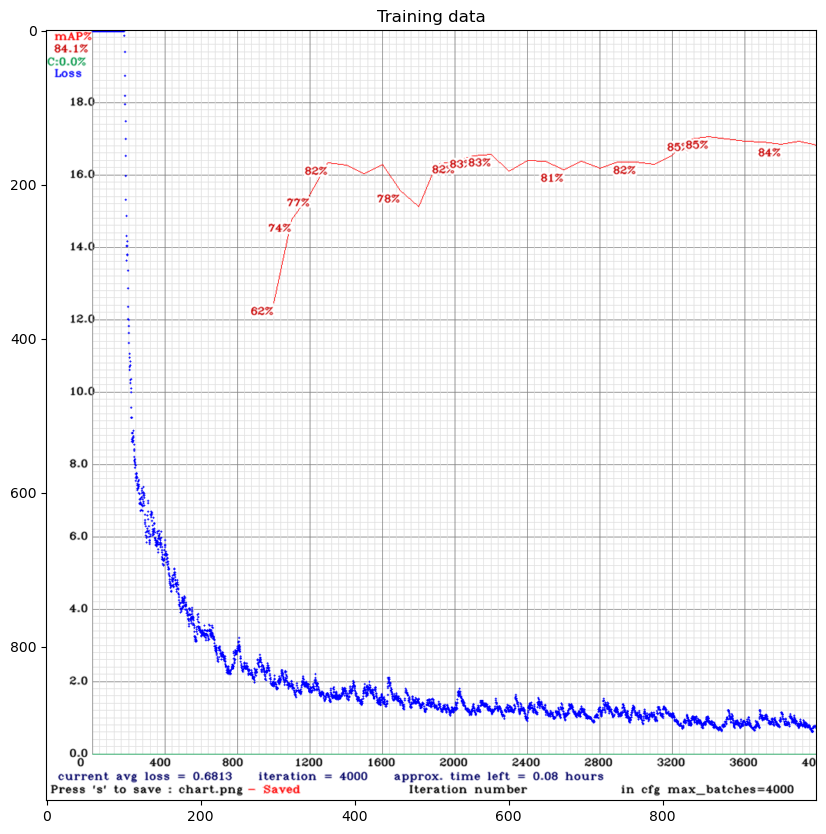

In [48]:
chart_file_name = f'{CONTENT_PATH}/chart_{YOLO_VERSION}.png'
print(chart_file_name, os.path.exists(chart_file_name))
if os.path.exists(chart_file_name):
    img_chart = cv2.imread(chart_file_name,1)
    plt.figure(figsize=[20,10])
    plt.title("Training data")
    plt.imshow(img_chart[:,:,::-1])

## Model Mean Average Precision

In [49]:
!{DARKNET_PATH} detector map {CONTENT_PATH}/mask.setup.data {CONTENT_PATH}/{YOLO_VERSION}.cfg {PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights

 CUDNN_HALF=1 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 217 K-images (3 Kilo-batches_64) 

 calculation mAP (mean average precision)...
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 

 detections_count = 5652, unique_truth_count = 2277  
 rank = 0 of ranks = 5652 
 rank = 100 of ranks = 5652 
 rank = 200 of ranks = 5652 
 rank = 300 of ranks = 5652 
 rank = 400 of ranks = 5652 
 rank = 500 of ranks = 5652 
 rank = 600 of ranks = 5652 
 rank = 700 of ranks = 5652 
 rank = 800 of ranks = 5652 
 rank = 900 of ranks = 5652 
 rank = 1000 of ranks = 5652 
 rank = 1100 of ranks = 5652 
 rank = 1200 of ranks = 5652 
 rank = 1300 of ranks = 5652 
 rank = 1400 of ranks = 5652 
 rank = 1500 of ranks = 5652 
 rank = 1600 of ranks = 5652 
 rank = 1700 of ranks = 5652 
 rank = 1800 of ranks = 5652 
 rank = 1900 of ranks = 5652 
 rank = 20

 CUDA-version: 11060 (12030), cuDNN: 8.3.2, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.5.5
 0 : compute_capability = 860, cudnn_half = 1, GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   3 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   5 conv    128       3 x 3/ 2    304 x 304 x  64 ->  152 x 152 x 128 3.407 BF
   6 conv     64       1 x 1/ 1    152 x 152 x 128 ->  152 x 152 x  64 0.379 BF
   7 conv    128       3 x 3/ 1    152 x 152 x  64 ->  152 x 152 x 128 3.407 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 152 x 152 x 128 0.003 BF
   9 conv     64       1 x 1/ 1    

# Running the inference using darknet

In [51]:
def move_predicted_output(src, dst):
    shutil.move(src, dst)

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("predictions.jpg")

    plt.figure(figsize=[15,15])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    plt.show()

def get_all_test_images(test_path):
    all_tests = [f for f in os.listdir(test_path) if not f.endswith('-pred.jpg') and f.endswith('jpg')]
    with open(f'{test_path}/image_test_files.txt', "w") as file:
        for file_name in all_tests:
            file.write(test_path+'/'+file_name + "\n")

    return all_tests

def load_all_images(img_path):
    images = []
    all_images = [f for f in os.listdir(img_path) if f.endswith('.jpg') ]
    all_images = sorted(all_images)
    for file_name in all_images:
        img = cv2.imread(img_path+'/'+file_name)
        images.append(img)
    return images


def show_all_images(images):
    plt.figure(figsize=[20,20])
    plt.subplot(421);plt.imshow(images[1][:,:,::-1]);plt.title("test-img1")
    plt.subplot(422);plt.imshow(images[0][:,:,::-1]);plt.title("pred-img1")
    plt.subplot(423);plt.imshow(images[3][:,:,::-1]);plt.title("test-img2")
    plt.subplot(424);plt.imshow(images[2][:,:,::-1]);plt.title("pred-img2")
    plt.subplot(425);plt.imshow(images[5][:,:,::-1]);plt.title("test-img3")
    plt.subplot(426);plt.imshow(images[4][:,:,::-1]);plt.title("pred-img3")
    plt.subplot(427);plt.imshow(images[7][:,:,::-1]);plt.title("test-img4")
    plt.subplot(428);plt.imshow(images[6][:,:,::-1]);plt.title("pred-img4")

#### Running all test images at once

 CUDNN_HALF=1 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 217 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content/test/test-image1.jpg: Predicted in 1435.942000 milli-seconds.
with_mask: 100%
 CUDNN_HALF=1 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 217 K-images (3 Kilo-batches_64) 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content/test/test-image2.jpg: Predicted in 1365.475000 milli-seconds.
with_mask: 100%
with_mask: 80%
with_mask: 75%
without_mask: 96%
with_mask: 97%
 CUDNN_HA

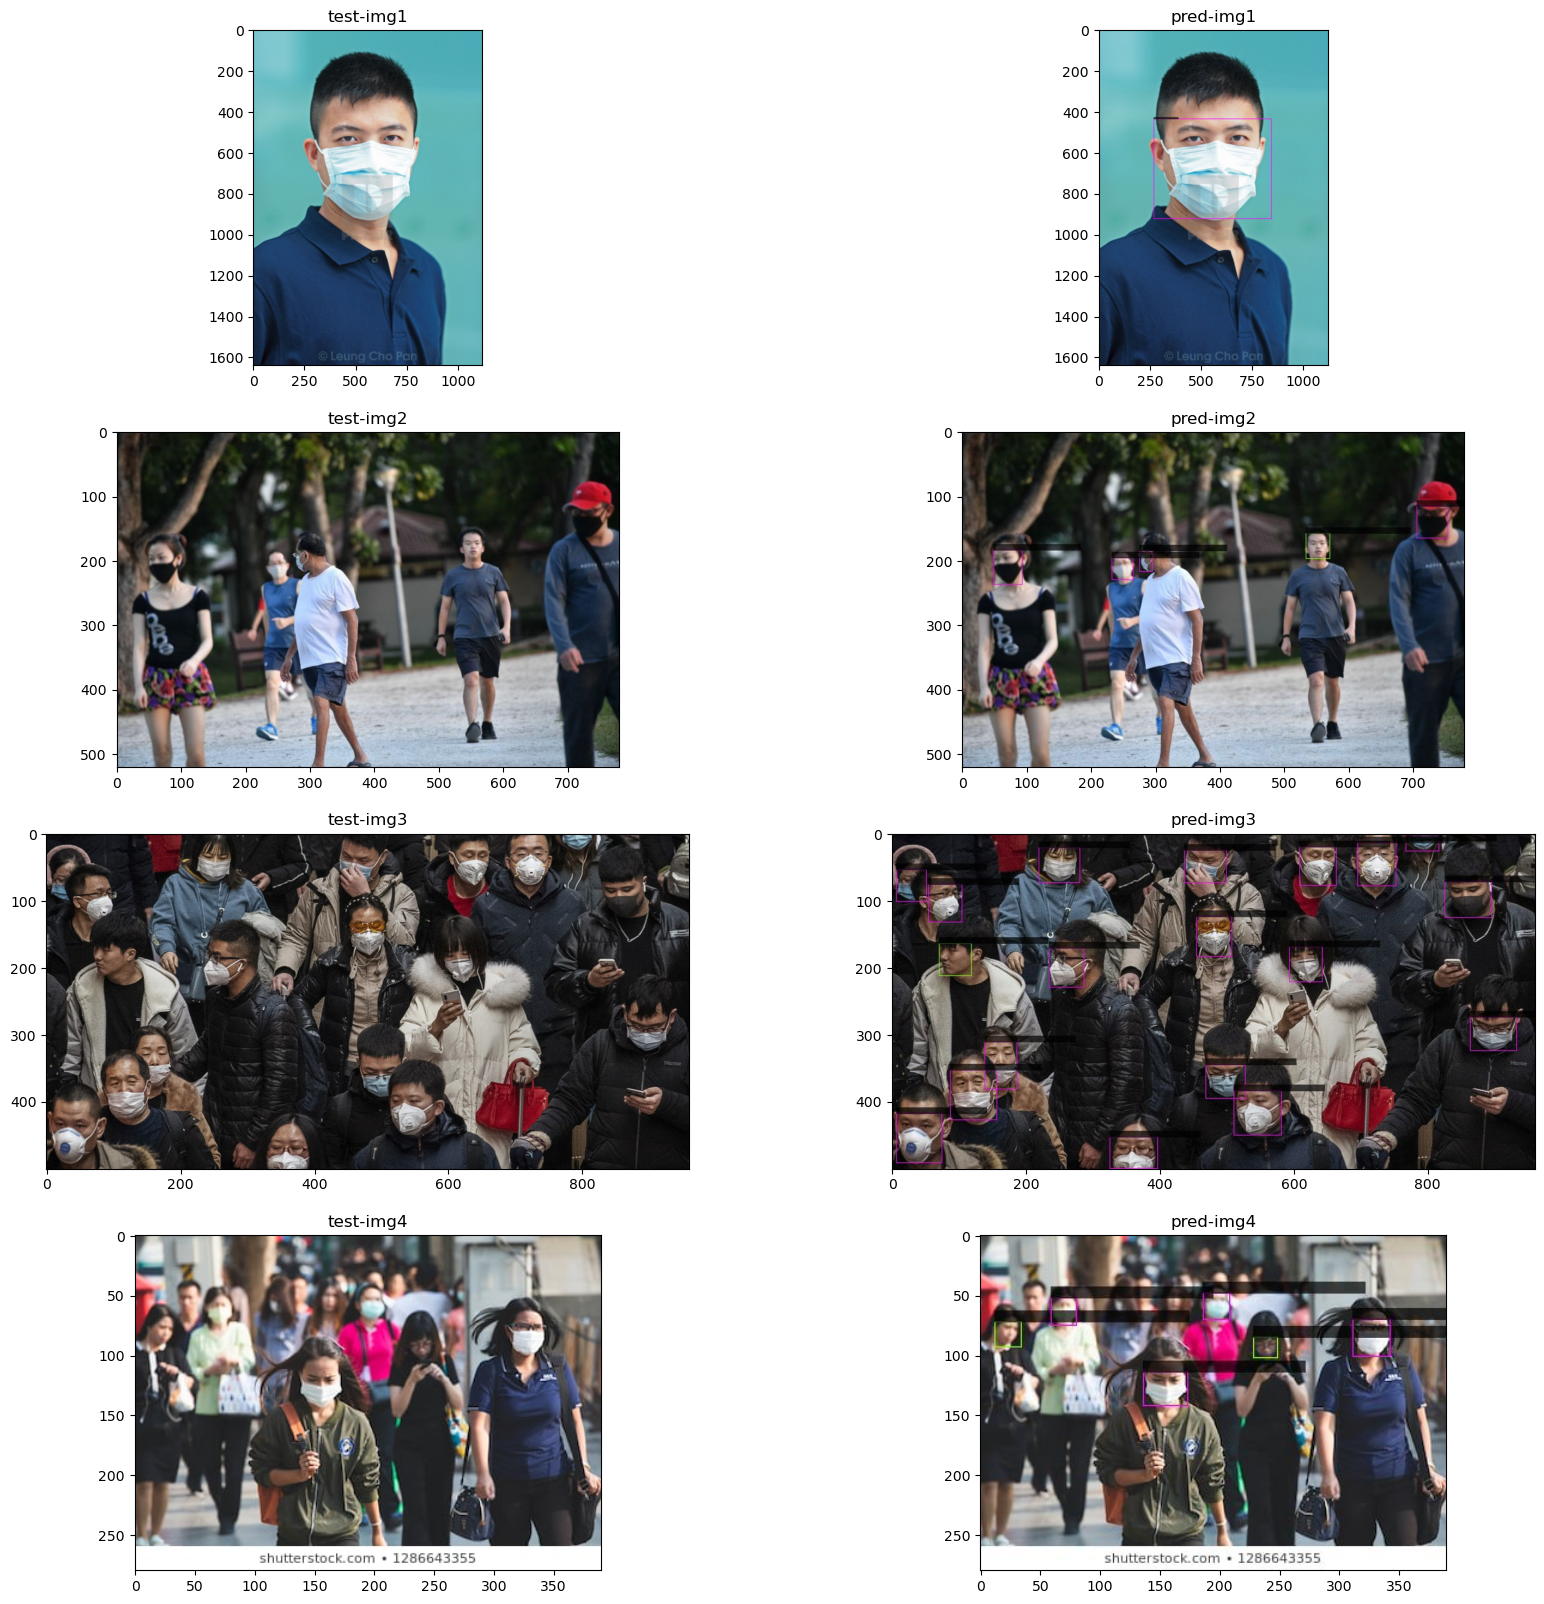

In [52]:
all_test_images = get_all_test_images(TEST_PATH)
for image in all_test_images:
    !{DARKNET_PATH} detector test \
    {CONTENT_PATH}/mask.setup.data \
    {CONTENT_PATH}/{YOLO_VERSION}_inference.cfg \
    {PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights \
    {CONTENT_PATH}/test/{image} \
    -dont_show -save_labels -thresh .6 2> /dev/null

    pred_name = image.replace('.jpg', '-pred.jpg')

    move_predicted_output('predictions.jpg', f'{CONTENT_PATH}/test/{pred_name}')

images = load_all_images(TEST_PATH)
show_all_images(images)

### Annotating images with OpenCV using the output text-file

Text(0.5, 1.0, 'pred-img4')

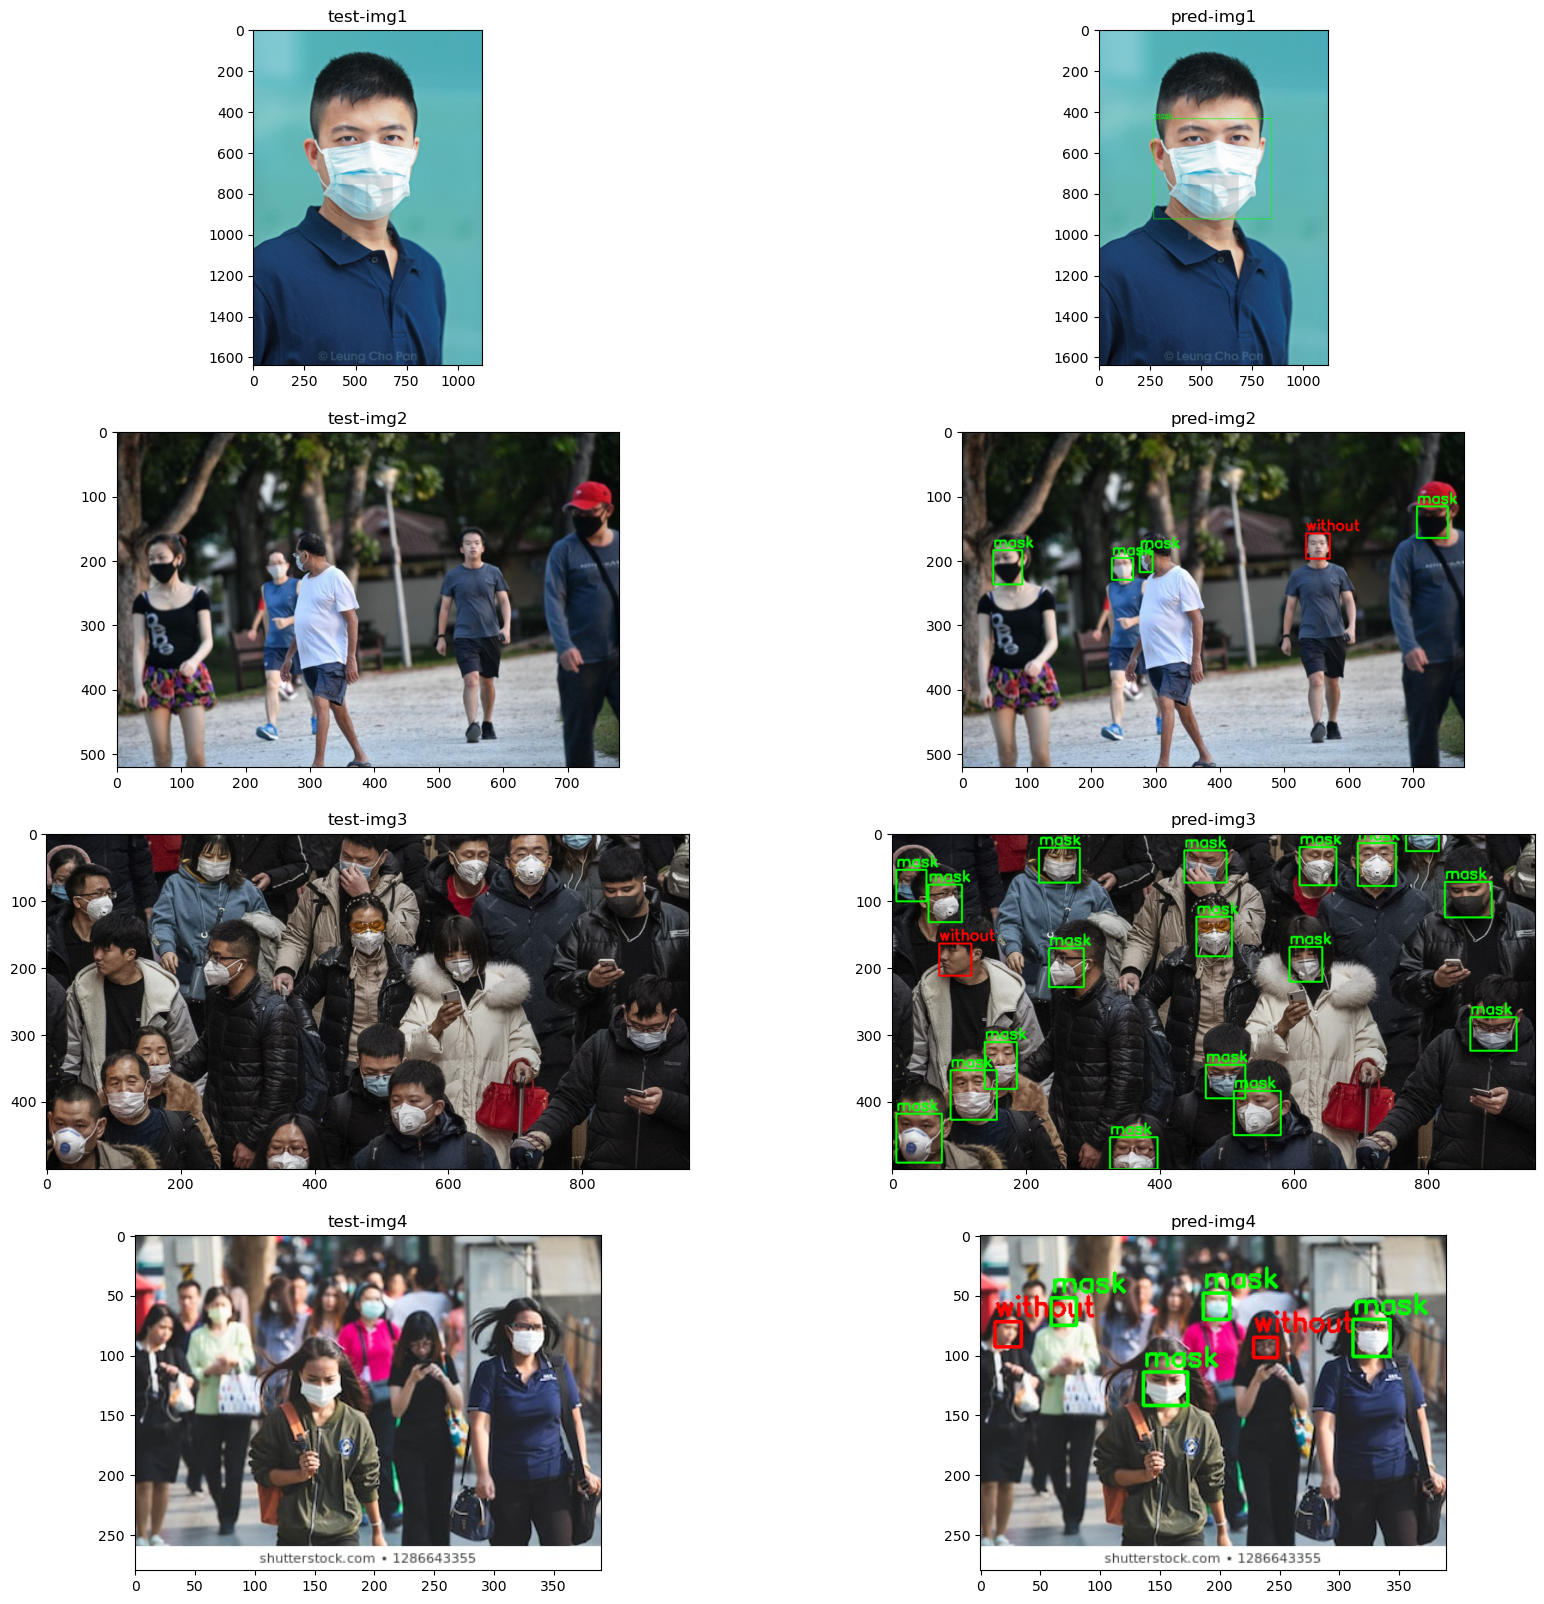

In [53]:
def draw_boxes(image, detections):
    class_labels = ['mask', 'without']
    thickness = adjust_thickness(image.shape[1], image.shape[0])
    font_size = adjust_font_size(image.shape[1], image.shape[0])
    for class_index, left, top, right, bottom in detections:
        colors = [(0, 255, 0), (0, 0, 255)]
        cv2.rectangle(image, (left, top), (right, bottom), colors[class_index], thickness)
        cv2.putText(image, class_labels[class_index], (left, top-5), cv2.FONT_HERSHEY_SIMPLEX, font_size, colors[class_index], thickness)
    return image

def adjust_thickness(image_width, image_height):
    thickness = int(min(image_width, image_height) / 400)
    return max(thickness, 2)

def adjust_font_size(image_width, image_height):
    font_size = min(image_width, image_height) / 1000
    return max(font_size, 0.75)

def parse_darknet_detection(output_text, image_width, image_height):
    lines = output_text.strip().split("\n")
    detections = []
    for line in lines:
        parts = line.split()
        class_index = int(parts[0])
        x, y, w, h = map(float, parts[1:])
        left = int((x - w / 2) * image_width)
        top = int((y - h / 2) * image_height)
        right = int((x + w / 2) * image_width)
        bottom = int((y + h / 2) * image_height)
        detections.append((class_index, left, top, right, bottom))
    return detections

all_images = []
all_test_images = get_all_test_images(TEST_PATH)
for image in all_test_images:

    text_file = image.replace('.jpg', '.txt')
    file_content = ''
    with open(f'{CONTENT_PATH}/test/{text_file}', 'r') as f:
        file_content = f.read()

    img = cv2.imread(f'{CONTENT_PATH}/test/{image}')
    detections = parse_darknet_detection(file_content, img.shape[1], img.shape[0])
    predicted = draw_boxes(img.copy(), detections)
    all_images.append(img)
    all_images.append(predicted)

plt.figure(figsize=[20,20])
plt.subplot(421);plt.imshow(all_images[0][:,:,::-1]);plt.title("test-img1")
plt.subplot(422);plt.imshow(all_images[1][:,:,::-1]);plt.title("pred-img1")
plt.subplot(423);plt.imshow(all_images[2][:,:,::-1]);plt.title("test-img2")
plt.subplot(424);plt.imshow(all_images[3][:,:,::-1]);plt.title("pred-img2")
plt.subplot(425);plt.imshow(all_images[4][:,:,::-1]);plt.title("test-img3")
plt.subplot(426);plt.imshow(all_images[5][:,:,::-1]);plt.title("pred-img3")
plt.subplot(427);plt.imshow(all_images[6][:,:,::-1]);plt.title("test-img4")
plt.subplot(428);plt.imshow(all_images[7][:,:,::-1]);plt.title("pred-img4")

## Running the inference inside OpenCV

In [54]:
model_configuration = f'{CONTENT_PATH}/{YOLO_VERSION}_inference.cfg'
model_weights =  f'{PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights'

darknet_yolo = cv2.dnn.readNetFromDarknet(model_configuration, model_weights)
darknet_yolo.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
darknet_yolo.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

yolo_layers = darknet_yolo.getLayerNames()
print(yolo_layers)

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37', 'bn_37', 'leaky_

## Initialize class labels

In [55]:
class_labels = ['mask', 'no_mask']
print("class_labels", class_labels)

class_labels ['mask', 'no_mask']


### Initialize box colors by classes

In [56]:
class_colors = ["0,255,0","0,0,255"]
class_colors = [np.array(every_color.split(",")).astype("int") for every_color in class_colors]
class_colors = np.array(class_colors)
class_colors = np.tile(class_colors,(7,1))

In [57]:
unconnected_layers = darknet_yolo.getUnconnectedOutLayers()
unconnected_layers

array([200, 227, 254])

In [58]:
yolo_output_layer = yolo_layers[unconnected_layers[-1:][0]-1]
yolo_output_layer

'yolo_106'

### Processing prediction output using non non-maximum suppression technique

Non-maximum suppression (NMS) is a post-processing technique used in object detection to eliminate duplicate detections and select the most relevant detected objects.  This helps reduce false positives and the computational complexity of a detection algorithm

In [60]:
def get_image_and_blob(img_path):
    if isinstance(img_path, str):
        img = cv2.imread(img_path)
    elif isinstance(img_path, np.ndarray):
        img = img_path.copy()

    blob = cv2.dnn.blobFromImage(img, 0.003922, (416, 416), swapRB=True, crop=False)
    return img, blob

def predict(model, prediction_layer, input_blob):
    model.setInput(input_blob)
    predicted = model.forward(prediction_layer)
    return predicted

def get_confidence(inference_data):
    scores = inference_data[5:]
    class_id = np.argmax(scores)
    confidence = scores[class_id]
    return class_id, confidence

def get_predicted_box_coords(inferece, width, height):
    bounding_box = inferece[0:4] * np.array([width, height, width, height])
    (box_center_x_pt, box_center_y_pt, box_width, box_height) = bounding_box.astype("int")
    start_x_pt = int(box_center_x_pt - (box_width / 2))
    start_y_pt = int(box_center_y_pt - (box_height / 2))
    return start_x_pt, start_y_pt, box_width, box_height

def process_inference_output(detection_layer, width, height, boxes, confidences, classes, scaled=False, unscaled_size=(0,0), offset={0,0}):
    found = False
    for inferece_output in detection_layer:
        predicted_class_id, prediction_confidence = get_confidence(inferece_output)
        if prediction_confidence >= THRESHOLD:
            found = True
            start_x_pt, start_y_pt, box_width, box_height = get_predicted_box_coords(inferece_output, width, height)

            if scaled:
                start_x_pt, start_y_pt, box_width, box_height = rescale_bbox(unscaled_size, (height, width), (start_x_pt, start_y_pt, box_width, box_height), offset)

            classes.append(predicted_class_id)
            confidences.append(float(prediction_confidence))
            boxes.append([start_x_pt, start_y_pt, int(box_width), int(box_height)])

    return found


def apply_nom_maximun_supression(boxes, confidences):
    best_values = cv2.dnn.NMSBoxes(boxes, confidences, THRESHOLD, 0.25)
    return best_values

def image_annotation(values_ids, boxes, classes, confidences, output_img, scaled=1):
    for max_valueid in values_ids:
        box = boxes[max_valueid]
        start_x_pt = box[0]
        start_y_pt = box[1]
        box_width = box[2]
        box_height = box[3]

        end_x_pt = start_x_pt + box_width
        end_y_pt = start_y_pt + box_height

        predicted_class_id = classes[max_valueid]
        predicted_class_label = class_labels[predicted_class_id]

        prediction_confidence = confidences[max_valueid]
        box_color = class_colors[predicted_class_id]
        box_color = [int(c) for c in box_color]

        cv2.rectangle(output_img, (start_x_pt, start_y_pt), (end_x_pt, end_y_pt), box_color, 2)
        cv2.putText(output_img, predicted_class_label, (start_x_pt, start_y_pt-5), cv2.FONT_HERSHEY_SIMPLEX, scaled*0.5, box_color, int(scaled*1))
    return output_img

def scale_image(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)

    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)

    return resized_image

def rescale_bbox(original_size, resized_size, bbox, offset):
    height_ratio = original_size[0] / resized_size[0]
    width_ratio = original_size[1] / resized_size[1]
    x_offset, y_offset = offset

    x = int(bbox[0] * width_ratio)-x_offset//2
    y = int(bbox[1] * height_ratio)-y_offset//2
    width = int(bbox[2] * width_ratio)+x_offset
    height = int(bbox[3] * height_ratio)+y_offset//2
    return x, y, width, height

def run_yolo(img_name, rescale_stage=False):
    class_ids_list = []
    confidences_list = []
    boxes_list = []

    img, input_blob = get_image_and_blob(img_name)
    img_to_detect = img.copy()
    img_height = img_to_detect.shape[0]
    img_width = img_to_detect.shape[1]

    obj_detection_layers = predict(darknet_yolo, yolo_output_layer, input_blob)
    t, _ = darknet_yolo.getPerfProfile()
    print('Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency()), 'detections', obj_detection_layers.shape)

    success = process_inference_output(obj_detection_layers, img_width, img_height, boxes_list, confidences_list, class_ids_list)
    scale_percent = 100
    step = 0
    if not success and rescale_stage:
        while (not success) and (step < 2):
            new_image = img.copy()
            height, width, _ = new_image.shape
            black_mask = np.zeros((height, width, 3), dtype=np.uint8)

            scale_percent //= 2
            resized_image = scale_image(new_image, scale_percent)
            new_height, new_width, _ = resized_image.shape

            x_offset = (width - resized_image.shape[1]) // 2
            y_offset = (height - resized_image.shape[0]) // 2
            black_mask[y_offset:y_offset+resized_image.shape[0], x_offset:x_offset+resized_image.shape[1]] = resized_image

            new_blob = cv2.dnn.blobFromImage(black_mask, 0.003922, (416, 416), swapRB=True, crop=False)
            scaled_output = predict(darknet_yolo, yolo_output_layer, new_blob)
            t, _ = darknet_yolo.getPerfProfile()

            sucess = process_inference_output(scaled_output, new_width, new_height, boxes_list, confidences_list, class_ids_list, True, (height, width), (x_offset, y_offset))
            if sucess: break
            step += 1


    max_value_ids = apply_nom_maximun_supression(boxes_list, confidences_list)
    output_img = image_annotation(max_value_ids, boxes_list, class_ids_list, confidences_list, img_to_detect, scaled=(100/scale_percent))
    return output_img

Inference time: 643.24 ms detections (8112, 7)


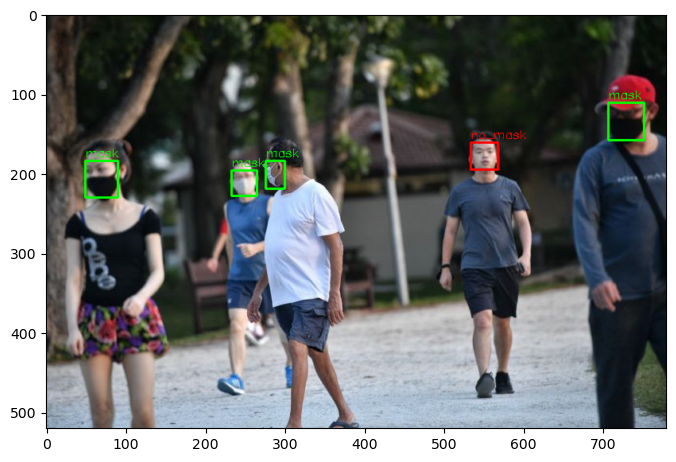

In [61]:
processed_image = run_yolo(f'{CONTENT_PATH}/test/test-image2.jpg')

plt.figure(figsize=[8,8])
plt.imshow(processed_image[:,:,::-1])

# Processing Video Files

### The input version

In [62]:
%%HTML
<div style="width: 100%; overflow: hidden;">

<div style="width: 600px; float: left;">
<span>video 1</span></br>
<video controls>
    <source src='content/test/test-video1.mp4' type="video/mp4">
</video>
</div>

<div style="margin-left: 620px;">
<span>video 2</span></br>
<video controls>
    <source src='content/test/test-video2.mp4' type="video/mp4">
</video>

</div>
</div>

#### processing video files using darknet detector demo and annotate output video using OpenCV

In [63]:
if RUNNING_IN_LINUX:
  writer_codec = cv2.VideoWriter_fourcc('F','M','P','4')
else:
  writer_codec = cv2.VideoWriter_fourcc('H','2','6','4')

In [64]:
def video_annotations_from_json(image, detections, class_labels):
    colors = [(0, 255, 0), (0, 0, 255)]  # Example colors
    thickness = adjust_thickness(image.shape[1], image.shape[0])
    font_size = adjust_font_size(image.shape[1], image.shape[0])
    frame_id = detections["frame_id"]
    objects = detections["objects"]
    for obj_info in objects:
        class_id = obj_info["class_id"]
        class_name = class_labels[class_id]
        relative_coordinates = obj_info["relative_coordinates"]
        confidence = obj_info["confidence"]

        left = int((relative_coordinates["center_x"] - relative_coordinates["width"] / 2) * image.shape[1])
        top = int((relative_coordinates["center_y"] - relative_coordinates["height"] / 2) * image.shape[0])
        right = int((relative_coordinates["center_x"] + relative_coordinates["width"] / 2) * image.shape[1])
        bottom = int((relative_coordinates["center_y"] + relative_coordinates["height"] / 2) * image.shape[0])

        color = colors[class_id % len(colors)]
        cv2.rectangle(image, (left, top), (right, bottom), color, thickness)
        cv2.putText(image, f"{class_name}: {confidence:.2f}", (left, top-5), cv2.FONT_HERSHEY_SIMPLEX, font_size, color, thickness)
    return image

def process_video_file(input_file):
  video_file = f'{CONTENT_PATH}/test/{input_file}'
  default_name = os.path.splitext(input_file)[0]
  output_directory = f'{CONTENT_PATH}/test/{default_name}'
  if not os.path.exists(output_directory):
    os.makedirs(output_directory)

  !{DARKNET_PATH} detector demo \
  {CONTENT_PATH}/mask.setup.data \
  {CONTENT_PATH}/{YOLO_VERSION}_inference.cfg \
  {PATH_TO_DATASET}/backup/{YOLO_VERSION}_best.weights \
  -ext_output -dont_show -save_labels -thresh .51 -i 0 \
  {video_file} \
  -json_file_output {output_directory}/{default_name}.json

  reference_video = cv2.VideoCapture(video_file)
  if (reference_video.isOpened()== False):
    print("Error opening video stream or file")
    return

  fourcc = reference_video.get(cv2.CAP_PROP_FOURCC)
  codec = "".join([chr((int(fourcc) >> 8 * i) & 0xFF) for i in range(4)])
  print("video_file", video_file, "codec", codec)

  width = int(reference_video.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(reference_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frame_count = int(reference_video.get(cv2.CAP_PROP_FRAME_COUNT))
  fps = reference_video.get(cv2.CAP_PROP_FPS)
  out_filename= f'{output_directory}/{default_name}_result.mp4'

  output_video_writer = cv2.VideoWriter(filename=out_filename,
                                fourcc=writer_codec,
                                frameSize=(width, height), fps=fps)

  json_metadata = None
  with open(f'{output_directory}/{default_name}.json', "r") as json_file:
      json_metadata = json.load(json_file)


  print('len(json_metadata)', len(json_metadata), 'frame_count', frame_count)

  frame_index = 0
  while reference_video.isOpened() and frame_index < len(json_metadata):
    ret, frame = reference_video.read()
    if not ret:
        break

    annotated_frame = video_annotations_from_json(frame, json_metadata[frame_index], class_labels)
    output_video_writer.write(annotated_frame)
    frame_index += 1

  reference_video.release()
  output_video_writer.release()

process_video_file('test-video1.mp4')
process_video_file('test-video2.mp4')

 CUDA-version: 11060 (12030), cuDNN: 8.3.2, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.5.5
[ WARN:0@0.127] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/32_0.png'): can't open/read file: check file path/integrity
Cannot load image data/labels/32_0.png
[ WARN:0@0.127] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/33_0.png'): can't open/read file: check file path/integrity
Cannot load image data/labels/33_0.png
[ WARN:0@0.128] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/34_0.png'): can't open/read file: check file path/integrity
Cannot load image data/labels/34_0.png
[ WARN:0@0.128] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/35_0.png'): can't open/read file: check file path/integ

 CUDNN_HALF=1 
Demo
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
Create CUDA-stream - 0 
 Create cudnn-handle 0 

 seen 64, trained: 217 K-images (3 Kilo-batches_64) 
video file: c:\opencv.org\DLAP\opencv_dlap_projects\Project-04-Train-a-Face-Mask-Detector\content/test/test-video1.mp4
Video stream: 1600 x 842 
Objects:


FPS:0.0 	 AVG_FPS:0.0
Objects:

without_mask: 100% 	(left_x:  371   top_y:  258   width:  143   height:  173)
without_mask: 99% 	(left_x: 1160   top_y:  379   width:  154   height:  199)
without_mask: 99% 	(left_x:  919   top_y:  349   width:  129   height:  155)
without_mask: 99% 	(left_x:  690   top_y:  460   width:  147   height:  210)
without_mask: 97% 	(left_x:  781   top_y:  175   width:   53   height:   71)

FPS:4.7 	 AVG_FPS:0.0
Objects:

without_mask: 100% 	(left_x:  370   top_y:  258   width:  143   height:  173)
without_mask: 99% 	(left_x: 1159   top_y:  380   width:  155   height:  197)
without_mask: 99% 	(left_x:  919   t

 CUDA-version: 11060 (12030), cuDNN: 8.3.2, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.5.5
[ WARN:0@0.127] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/32_0.png'): can't open/read file: check file path/integrity
Cannot load image data/labels/32_0.png
[ WARN:0@0.127] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/33_0.png'): can't open/read file: check file path/integrity
Cannot load image data/labels/33_0.png
[ WARN:0@0.128] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/34_0.png'): can't open/read file: check file path/integrity
Cannot load image data/labels/34_0.png
[ WARN:0@0.128] global C:\Program Files\opencv\opencv-4.5.5\modules\imgcodecs\src\loadsave.cpp (239) cv::findDecoder imread_('data/labels/35_0.png'): can't open/read file: check file path/integ

#### Show output videos

If you can't see the videos due of Google Colab impatibility, download the videos locally to your local machine and watch them with your favorite player.

Test Video 1 personal output 
https://youtu.be/g0cwUCYHHjk


Test Video 2 personal output 
https://youtu.be/rLvYi5HAZ6I

In [66]:
%%HTML
<div style="width: 100%; overflow: hidden;">

<div style="width: 600px; float: left;">
<span>video 1</span></br>
<video controls>
    <source src='content/test/test-video1/test-video1_result.mp4' type="video/mp4">
</video>
</div>

<div style="margin-left: 620px;">
<span>video 2</span></br>
<video controls>
    <source src='content/test/test-video2/test-video2_result.mp4' type="video/mp4">
</video>

</div>
</div>